In [2]:
import cv2
import keras
import matplotlib.pyplot as plt
import numpy as np
import scipy.fftpack as sp
from PIL import Image
import math
from tqdm import tqdm

In [3]:
def signaltonoise(a):
    a = np.asanyarray(a)
    m = a.mean(None)
    sd = a.std()
    return np.where(sd == 0, 0, m/sd)

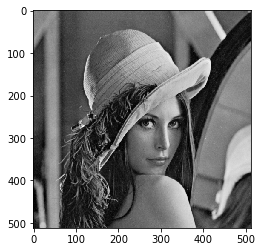

(512, 512)


In [14]:
data_dir = r"C:\Users\callu\Pictures\Test\\"
img = Image.open(data_dir+"lena.png")
img = np.asarray(img)
plt.imshow(img[:,:,1], cmap="gray")
plt.show()
print(img[:,:,1].shape)

In [28]:
conim = sp.dct(img[:,:,1], norm='ortho')
plt.imshow(conim, cmap="gray")
plt.show()
print(conim)
newim = sp.idct(conim, norm='ortho')
plt.imshow(newim, cmap="gray")
plt.show()
img=img[:,:,1]
print(img)

IndexError: too many indices for array

The *dctTransform* function defined below is an implementation from first principles using the algorithm used for 2D discrete cosine transforms.
Essentially, this is just a basic, effective (albeit inefficient) implementation of the algorithm.

https://uk.mathworks.com/help/vision/ref/2ddct.html was used as a good resource whilst building this.

In [16]:
def dctTransform(matrix):
    m = matrix.shape[0]
    n = matrix.shape[1]
    result = np.zeros((m,n))
    
    cu = 0
    cv = 0
    dct_temp = 0
    total = 0
    
    for u in range(0,m):
        for v in range(0,n):
            if (u == 0):
                cu = 1/math.sqrt(m); 
            else:
                cu = math.sqrt(2)/math.sqrt(m); 
            if (v == 0):
                cv = 1/math.sqrt(n); 
            else:
                cv = math.sqrt(2)/math.sqrt(n); 
            
            for y in range(0,m):
                for x in range(0,n):
                    dct_temp = matrix[y,x]*math.cos(v*math.pi*(((2*y)+1)/(2*m)))*math.cos(u*math.pi*(((2*x)+1)/(2*n)))
                    total = total+dct_temp
            result[v,u] = cu*cv*total
            total=0        
    return result

Below the *idctTransform* function is defined, using the inverse discrete cosine transform function as a basis. This is very similar to the code and strategy used for the initial *dctTransform* function, but does have minor differences.

https://uk.mathworks.com/help/images/ref/idct2.html?searchHighlight=inverse%20dct2&s_tid=doc_srchtitle#f4-165780 was used as a good resource whilst building this solution.

In [17]:
def idctTransform(tmatrix):
    m = tmatrix.shape[0]
    n = tmatrix.shape[1]
    result = np.zeros((m,n))
    
    ap = 0
    aq = 0
    idct_temp = 0
    total = 0
    
    for y in range(0,m):
        for x in range(0,n):
            for p in range(0,m):
                for q in range(0,n):
                    if (p == 0):
                        ap = 1/math.sqrt(m); 
                    else:
                        ap = math.sqrt(2/m); 
                    if (q == 0):
                        aq = 1/math.sqrt(n); 
                    else:
                        aq = math.sqrt(2/n); 
                
                    total += ap*aq*tmatrix[q,p]*math.cos(p*math.pi*(((2*y)+1)/(2*m)))*math.cos(q*math.pi*(((2*x)+1)/(2*n)))    
            result[x,y] = total
            total = 0
    return result

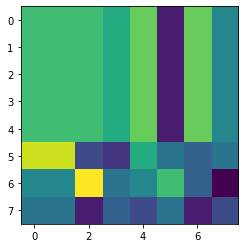

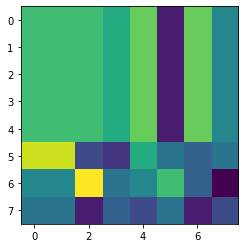

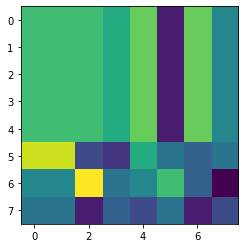

In [18]:
#print(img[0:8,0:8])
#print(dctTransform(img[0:8,0:8]))
#print(idctTransform(dctTransform(img[0:8,0:8])))
#print(sp.dct(img[0:8,0:8]))
#print(sp.idct(sp.dct(img[0:8,0:8])))
plt.imshow(img[0:8,0:8])
plt.show()
plt.imshow(sp.idct(sp.dct(img[0:8,0:8])))
plt.show()
#plt.imshow(dctTransform(img[0:8,0:8]))
#plt.show()
plt.imshow(idctTransform(dctTransform(img[0:8,0:8])))
plt.show()
#plt.imshow(img)
#plt.show()

The next cell just divides an image (in this case *lena.png*) into **4x4, 8x8 and 16x16 blocks** and performs DCT on each.

It then reconstructs the original image from these constituent blocks (thus acting as proof that the transform is working as intended and compression modifications can start being made.

Due to the unoptimised nature of the code here, it takes a while to run [*about 6-7 minutes on my home machine*]

100%|██████████| 32/32 [07:37<00:00, 14.31s/it]


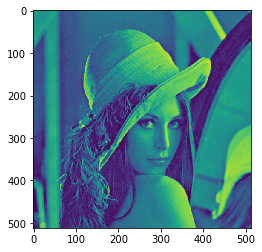

In [19]:
def dctTest(block_size, img):
    recon = np.zeros(img.shape)
    m = img.shape[0]
    n = img.shape[1]
    for i in tqdm(range(m//block_size)):
        for j in range(n//block_size):
            block = img[i*block_size:(i+1)*block_size,j*block_size:(j+1)*block_size]
            dct_block = dctTransform(block)
            recon_block = idctTransform(dct_block)
            recon[i*block_size:(i+1)*block_size,j*block_size:(j+1)*block_size] = recon_block
    return recon

bfour = dctTest(4,img)
beight = dctTest(8,img)
bsixteen = dctTest(16,img)
plt.imshow(bsixteen)
plt.show()

The code below runs MSE on each of the reconstituted images above, to get their MSE:
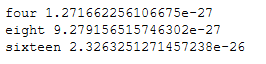

In [20]:
MSE = np.square(np.subtract(img,bfour)).mean()
print("four",MSE)
MSE = np.square(np.subtract(img,beight)).mean()
print("eight",MSE)
MSE = np.square(np.subtract(img,bsixteen)).mean()
print("sixteen",MSE)

four 1.127572702164575e-27
eight 8.168469230584057e-27
sixteen 2.3193359384365933e-26


In [21]:
def dctThresh(block_size,img, thresh):
    recon = np.zeros(img.shape)
    m = img.shape[0]
    n = img.shape[1]
    for i in tqdm(range(m//block_size)):
        for j in range(n//block_size):
            block = img[i*block_size:(i+1)*block_size,j*block_size:(j+1)*block_size]
            dct_block = dctTransform(block)
            bign = 0
            bigs = 0
            for r in dct_block:
                for c in r:
                    if c>bigs:
                        if c>bign:
                            bigs=bign
                            bign=c
                        bigs=c
            for x in range(block_size):
                for y in range(block_size):
                    if abs(dct_block[x,y])<thresh*bigs:
                        dct_block[x,y] = 0
            recon_block = idctTransform(dct_block)
            recon[i*block_size:(i+1)*block_size,j*block_size:(j+1)*block_size] = recon_block
    return recon

100%|██████████| 64/64 [01:59<00:00,  1.86s/it]


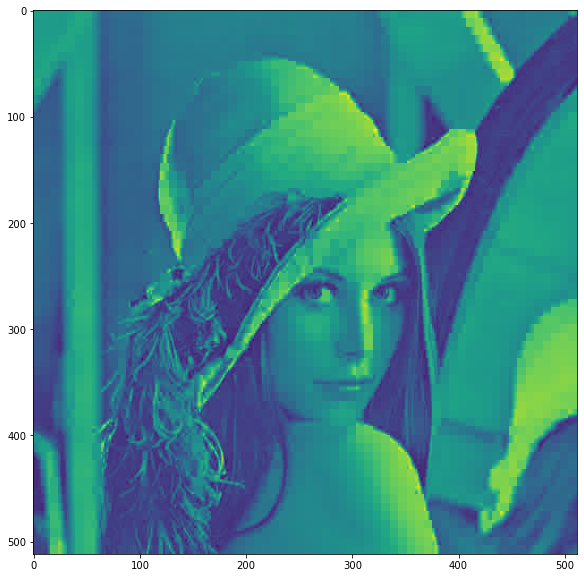

In [22]:
teight = dctThresh(8,img,0.1)
plt.figure(figsize=(10,10))
plt.imshow(teight)
plt.show()

The signal-to-noise ratio for the resultant image can be measured using the method specified at the beginning of this notebook

In [24]:
print(signaltonoise(teight))

1.9027134888243842


In [29]:
def quantise(block):
    target = np.array([[8,8,6,6,4,4,2,2],
                       [8,8,6,6,4,4,2,2],
                       [6,6,6,6,4,4,2,2],
                       [6,6,6,6,4,4,2,2],
                       [4,4,4,4,4,4,2,2],
                       [4,4,4,4,4,4,2,2],
                       [2,2,2,2,2,2,2,2],
                       [2,2,2,2,2,2,2,2]],np.int32)
    quant = np.zeros(target.shape)
    #print(target)
    for x in range(block.shape[0]):
        for y in range(block.shape[1]):
            quant[x,y] = round(block[x,y]/target[x,y])
    return quant
print(quantise(dctTransform(img[0:8,0:8])))

[[135.   1.   0.  -0.   0.   0.  -4.   4.]
 [  1.  -0.   0.  -1.   1.   1.  -3.   3.]
 [ -1.  -0.  -0.   0.  -0.  -0.   2.  -2.]
 [  0.   0.   0.   0.  -0.  -0.   0.   0.]
 [ -0.  -1.   0.  -0.   1.   0.  -1.  -0.]
 [  0.   0.  -1.  -0.  -1.   0.   1.   1.]
 [ -1.   0.   2.   1.   1.  -1.  -1.  -1.]
 [  1.  -0.  -2.  -1.  -1.   1.   1.   1.]]


In [30]:
def dctQuantThresh(block_size,img, thresh):
    recon = np.zeros(img.shape)
    m = img.shape[0]
    n = img.shape[1]
    for i in tqdm(range(m//block_size)):
        for j in range(n//block_size):
            block = img[i*block_size:(i+1)*block_size,j*block_size:(j+1)*block_size]
            dct_block = dctTransform(block)
            bign = 0
            bigs = 0
            for r in dct_block:
                for c in r:
                    if c>bigs:
                        if c>bign:
                            bigs=bign
                            bign=c
                        bigs=c
            for x in range(block_size):
                for y in range(block_size):
                    if abs(dct_block[x,y])<thresh*bigs:
                        dct_block[x,y] = 0
            dct_block = quantise(dct_block)
            recon_block = idctTransform(dct_block)
            recon[i*block_size:(i+1)*block_size,j*block_size:(j+1)*block_size] = recon_block
    return recon

100%|██████████| 64/64 [01:59<00:00,  1.87s/it]


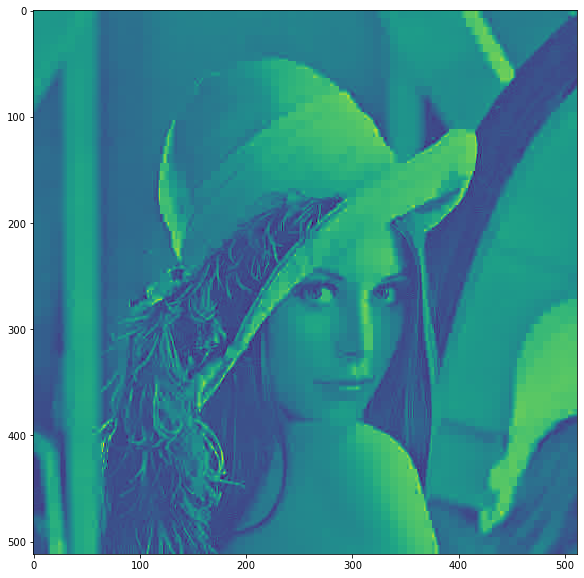

In [31]:
qteight = dctQuantThresh(8,img,0.1)
plt.figure(figsize=(10,10))
plt.imshow(qteight)
plt.show()

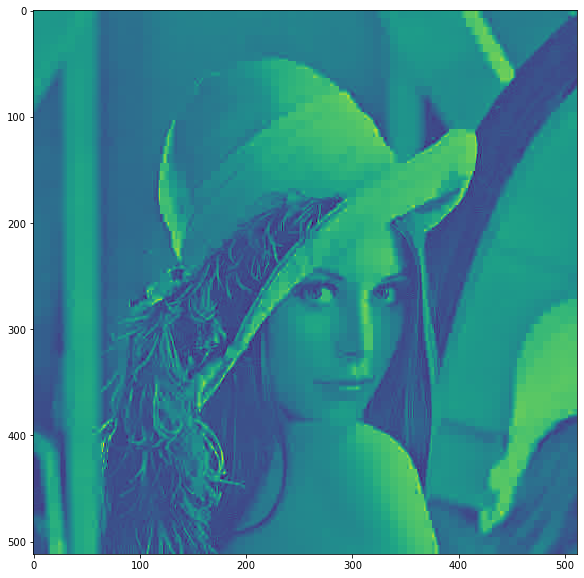

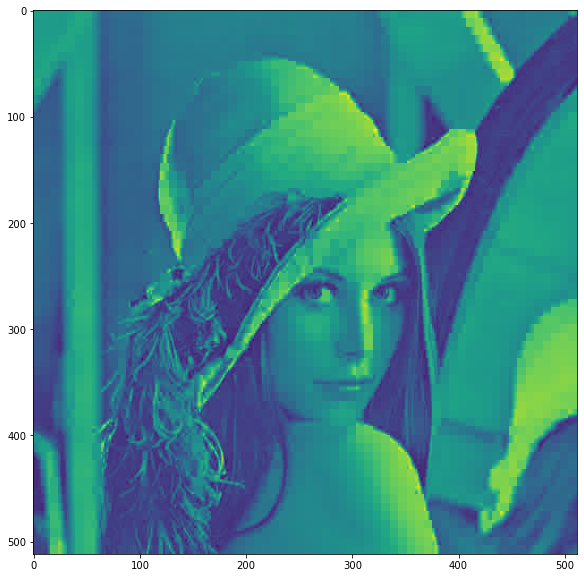

In [32]:
plt.figure(figsize=(10,10))
plt.imshow(qteight)
plt.show()
plt.figure(figsize=(10,10))
plt.imshow(teight)
plt.show()

This cell simply uses the code given in labs to generate gaussian kernels for blurring via convolution of a given **size** and **sigma**

In [33]:
def gaussian_kernel(sigma, norm=True):
    
    size = int(np.ceil(6 * sigma))  # kernel width is 6 x sigma
    
    if (size%2==0): # is the size even?
        size = size + 1 # make it odd 
        
    kernel = np.zeros((size,size), dtype='float') # kernel array
    
    h = size//2 # half size
    for y in range(0,size):
        for x in range(0,size):
            x2 = (x-h)*(x-h)
            y2 = (y-h)*(y-h)
            kernel[y, x] = np.exp(-(x2+y2)/(2*sigma*sigma))
    
    if norm:
        kernel /= np.sum(kernel) # normalise the kernel
    
    return kernel

Likewise, this cell uses code from the labs to convolve a given **kernel** over a given image **im**

In [34]:
def conv2d(im, kernel):

    h = kernel.shape[0]//2 # half the kernel size
    impad = np.pad(im,h,"edge")
    output = np.zeros(im.shape, dtype='float')
    for i in range(h,impad.shape[0]-h):
        for j in range(h,impad.shape[1]-h):

            output[i-h, j-h] = np.dot(impad[i-h:i+h+1,j-h:j+h+1].flatten(), kernel.flatten())
    return output

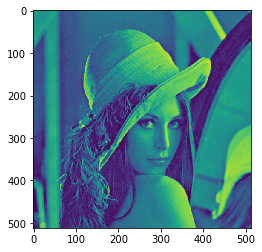

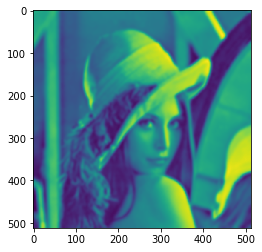

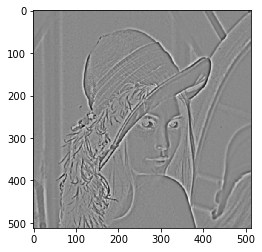

In [35]:
plt.imshow(img)
plt.show()

big = gaussian_kernel(3)
smol = gaussian_kernel(1)

blurred = conv2d(img,big)
padded_kernel = np.pad(smol, (big.shape[0]-smol.shape[0])//2, 'constant')
dog = big - padded_kernel

plt.imshow(blurred)
plt.show()

dogged = conv2d(img,dog)
plt.imshow(dogged, cmap="gray")
plt.show()

REDUCE and EXPAND are both methods developed from first principles that perform the corresponding operations. These were more-or-less taken from work done in labs on the subject.

In [36]:
def reduce(im, kernel):
    
    # blur the input 
    im_blurred = conv2d(im.astype('float'), kernel)
    plt.imshow(im_blurred)
    plt.show()
    print(im_blurred.shape)
    return im_blurred[::2,::2] # return subsampled version

def expand(im, kernel):

    # upsample by a factor of two by pixel duplication
    upsampled = np.zeros((2*im.shape[0], 2*im.shape[1]), dtype=im.dtype)
    print(upsampled.shape)
    for i in range(upsampled.shape[0]):
        for j in range(upsampled.shape[1]):
            upsampled[i, j] = im[i//2,j//2]

    # blur the upsampled image
    blurred = conv2d(upsampled.astype('float'), kernel)

    return blurred

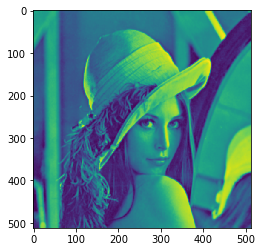

(512, 512)
(512, 512)


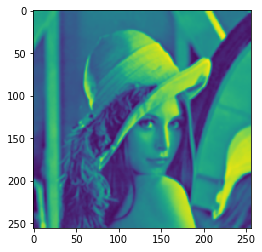

(256, 256)
(256, 256)


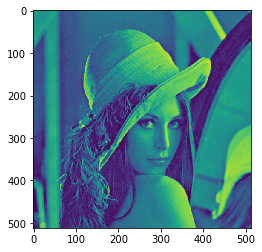

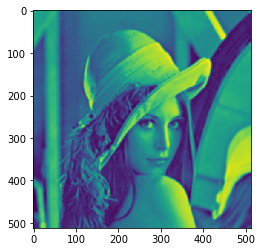

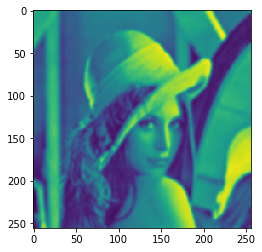

In [37]:
red1 = reduce(img,smol)
exp1 = expand(red1,smol)

red2 = reduce(red1,smol)
exp2 = expand(red2,smol)

plt.imshow(img)
plt.show()
plt.imshow(exp1)
plt.show()
plt.imshow(exp2)

*build_pyramids()* applies the created REDUCE and EXPAND operations such that laplacian and gaussian pyramids are constructed for a given images of a squre size that is a power of 2

In [38]:
def build_pyramids(img, g):
    gauss_pyramid = [] # list to store the generated levels

    gauss_pyramid.append(img.astype('float')) # level 0 is the image

    n = int(np.log2(img.shape[0]))+1 # assume that the image size is a power of 2
    for i in range(1,n):

        print(i)
        
        level = reduce(gauss_pyramid[i-1], g)

        gauss_pyramid.append(level)

    lap_pyramid=[]
    for j in range(0,n-1):
        diff = gauss_pyramid[j]-expand(gauss_pyramid[j+1],g)
        lap_pyramid.append(diff)

    return gauss_pyramid,lap_pyramid

def show_pyramid(pyramid):

        fig = plt.figure(figsize=(18,7))

        for i in range(len(pyramid)):

            plt.subplot(2,5,i+1)
            plt.imshow(pyramid[i], cmap='gray')
            plt.title('level '+str(i))
            plt.xticks([])
            plt.yticks([])

        plt.show()

1


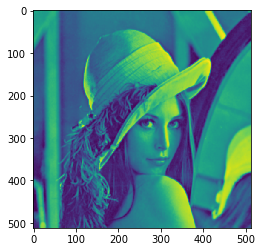

(512, 512)
2


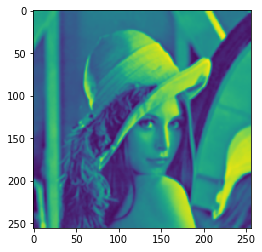

(256, 256)
3


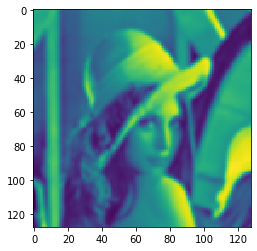

(128, 128)
4


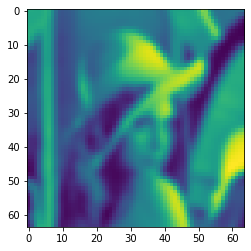

(64, 64)
5


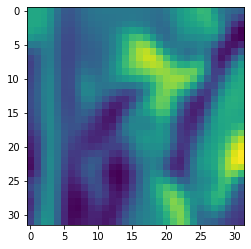

(32, 32)
6


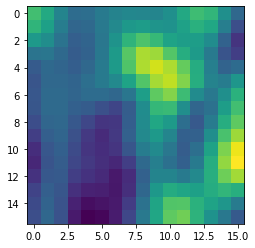

(16, 16)
7


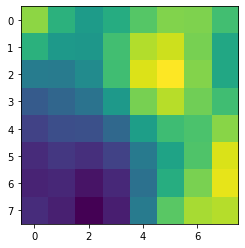

(8, 8)
8


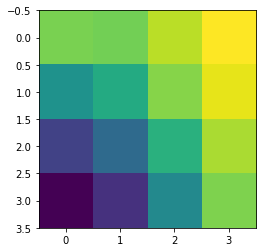

(4, 4)
9


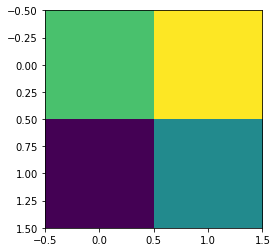

(2, 2)
(512, 512)
(256, 256)
(128, 128)
(64, 64)
(32, 32)
(16, 16)
(8, 8)
(4, 4)
(2, 2)


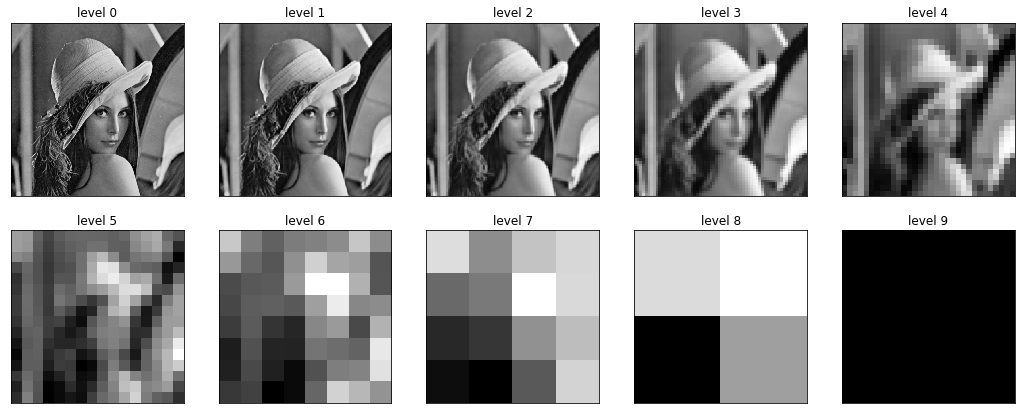

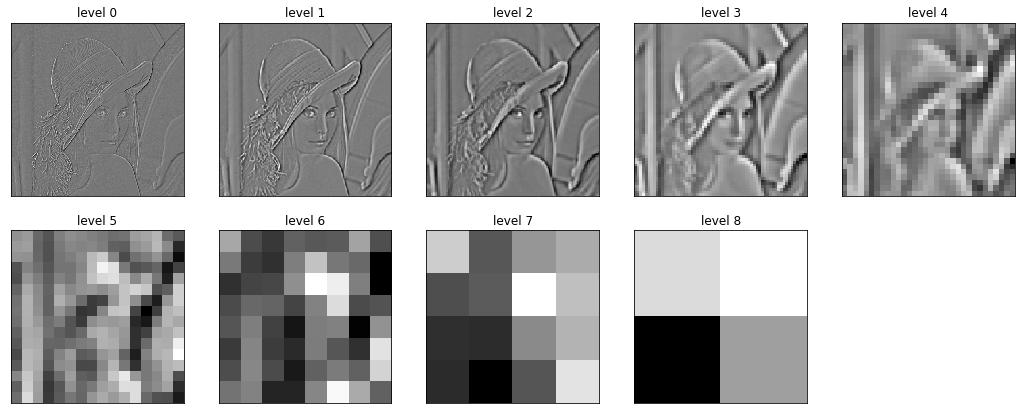

In [39]:
gauss,lapl = build_pyramids(img, smol)

show_pyramid(gauss)

show_pyramid(lapl)

Laplacian pyramid images are independently thresholded, letting all values below 2% of the maximum value to zero

107.15300003332143
81.45929439747871
84.37291792169432
65.85700841324464
69.16063354413754
56.0917833702037
40.79547037339134
18.800019039037707
8.041495848870213


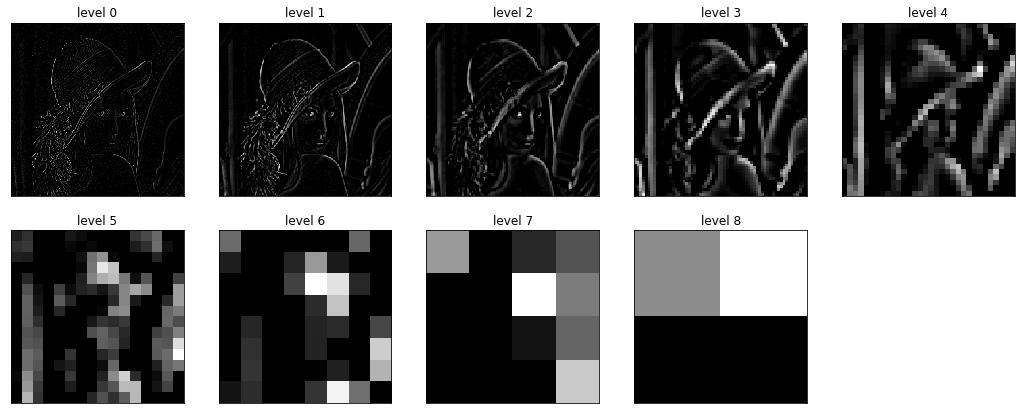

In [40]:
thresh_lap = []
for xj in range(len(lapl)):
    temp_store = []
    pmax = 0
    for pix in lapl[xj].ravel():
        if pix>pmax:
            pmax=pix
    print(pmax)
    for pix in lapl[xj].ravel():
        if pix>(0.02*pmax):
            temp_store.append(pix)
        else:
            temp_store.append(0)
    new_store = np.asarray(temp_store)
    thresh_lap.append(new_store.reshape((int(512//math.pow(2,(xj)))), int(512//math.pow(2,(xj)))))

show_pyramid(thresh_lap)

This excerpt combines the thresholded laplacian pyramid images with the original gaussian pyramid ones to reconstruct the original image (albeit in a more compressed/compressable form)

0
1
2
3
4
5
6
7
8
(512, 512)


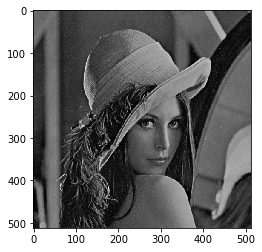

(256, 256)


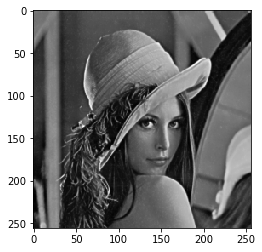

(128, 128)


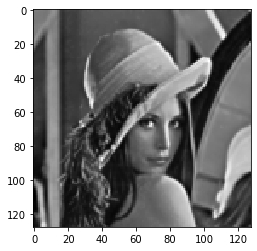

(64, 64)


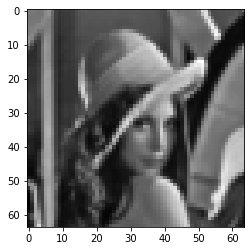

(32, 32)


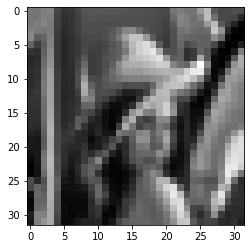

(16, 16)


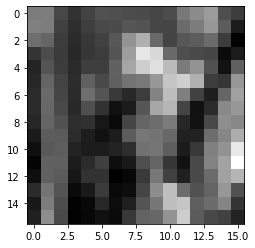

(8, 8)


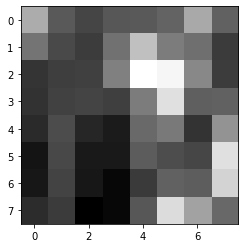

(4, 4)


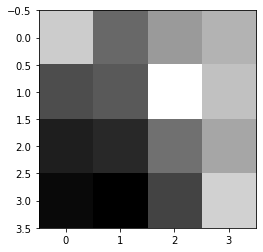

(2, 2)


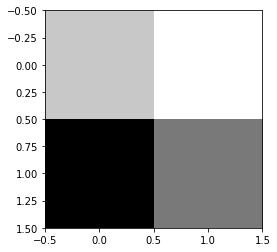

In [41]:
new_comb=[]
for level in range(len(thresh_lap)):
    print(level)
    new_comb.append(gauss[level] + thresh_lap[level])

for nc in new_comb:
    print(nc.shape)
    plt.imshow(nc,cmap='gray')
    plt.show()

The cell below simply finds the MSE for each of the reconstituted levels of the pyramid - accuracy decreases with level, though as fewer pixels remain actual MSE reduces

In [42]:
for i in range(8):
    mse = np.square(np.subtract(gauss[i],new_comb[i])).mean()
    print(i,':',mse)

0 : 55.66161077179064
1 : 65.87910912606998
2 : 100.26008847842812
3 : 167.328534977677
4 : 237.50834662666983
5 : 228.19143468050646
6 : 150.9653187868104
7 : 55.50351355374747
